In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

In [ ]:
df_csv = pd.read_csv('Misdrijven_W_B.csv', sep=';')
df_xls = pd.read_excel('kwb-2018.xls')
df_csv = df_csv.rename(columns={'WijkenEnBuurten': 'gwb_code_10'})
df = df_xls.merge(df_csv, on = 'gwb_code_10', how='inner')

df =df.replace({".": np.nan})

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '.')
        df[col] = pd.to_numeric(df[col], errors='ignore')






/var/folders/q8/wmshq4m10v9267157w6sf1ym0000gn/T/ipykernel_4615/807304900.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df =df.replace({".": np.nan})
/var/folders/q8/wmshq4m10v9267157w6sf1ym0000gn/T/ipykernel_4615/807304900.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


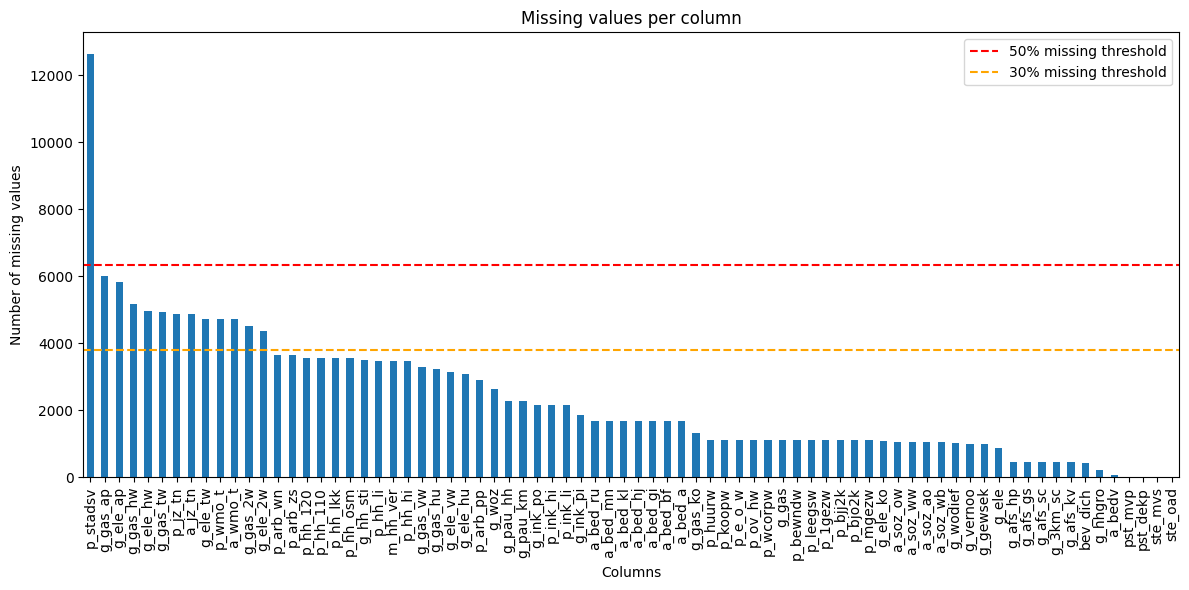

In [ ]:
missing = df.isna().sum()
missing = missing[missing>0].sort_values(ascending=False)

total_rows = len(df)
missing_perc_50 = 0.5 * total_rows
missing_perc_30 = 0.3 * total_rows


plt.figure(figsize=(12,6))
missing.plot(kind='bar')
plt.axhline(missing_perc_50, color = 'red', linestyle = '--', label = '50% missing threshold')
plt.axhline(missing_perc_30, color = 'orange', linestyle = '--', label = '30% missing threshold')
plt.title("Missing values per column")
plt.ylabel("Number of missing values")
plt.xlabel("Columns")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

df = df.dropna(subset=['TotaalGeweldsEnSeksueleMisdrijven_22'])

#p_stadsv has more than 50% missing values
df = df.drop(["p_stadsv"], axis=1)

#redundant rows
df = df.drop(["ind_wbi", "gwb_code_8"], axis=1)

#contain several missing values and relate to criminality
df = df.drop(["g_wodief", "g_vernoo", "g_gewsek"], axis =1)

#--> note that i have not yet disregarded columns with missing values >30% and <50%.
# What should we do with those?

In [ ]:


#KNN imputer to fill in missing values
dont_scale = ['gwb_code_10', 'regio', 'gm_naam', 'recs']


num_cols = df.select_dtypes(include=['float64', 'int64']).columns
scale_cols = [col for col in num_cols if col not in dont_scale]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5))
])

cat_cols = df.select_dtypes(include=['object']).columns
df_num_cols = df[scale_cols]
df_cat_cols = df[cat_cols]

df_num_cols_imputed = pipe.fit_transform(df_num_cols)
df_num_cols_imputed = pd.DataFrame(df_num_cols_imputed, columns = scale_cols, index = df.index)
df_scaled = pd.concat([df_cat_cols, df_num_cols_imputed], axis =1)


#reverse scaling to get original df for visualization purposes
scaler = pipe.named_steps['scaler']
df_num_unscaled = scaler.inverse_transform(df_num_cols_imputed)
df_num_unscaled = pd.DataFrame(df_num_unscaled, columns=scale_cols, index=df.index)
df_imputed = pd.concat([df_cat_cols, df_num_unscaled], axis=1)


